## экспорт из ЯД

In [ ]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/Xt2qqNtDXXE3xQ'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

dist_path = os.path.join(os.getcwd(), 'data')
zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=dist_path)

## обучение модели

In [1]:
import pickle

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

2024-06-01 18:02:04.734051: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 18:02:09.112313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import os

## НАСТРОЙКА

In [6]:
pd.read_csv(os.path.join(os.getcwd(), 'image_result_info.csv'), index_col=[0])

,video_name,video_num,image_name,frame_duration,target,description
0,0000000_00000020240221082923_0001_IMP (1).mp4,0,video_0_frame_0-01-33.03_flag_0_violation_0.jpg,0-01-33.03,0,NaN
1,0000000_00000020240221082923_0001_IMP (1).mp4,0,video_0_frame_0-01-33.09_flag_0_violation_0.jpg,0-01-33.09,0,NaN
2,0000000_00000020240221082923_0001_IMP (1).mp4,0,video_0_frame_0-01-33.19_flag_0_violation_0.jpg,0-01-33.19,0,NaN
3,0000000_00000020240221082923_0001_IMP (1).mp4,0,video_0_frame_0-01-33.26_flag_0_violation_0.jpg,0-01-33.26,0,NaN
4,0000000_00000020240221082923_0001_IMP (1).mp4,0,video_0_frame_0-01-33.36_flag_0_violation_0.jpg,0-01-33.36,0,NaN
...,...,...,...,...,...,...
11131,VID-20240301-WA0023.mp4,15,video_15_frame_0-02-22.61_flag_1_violation_33.jpg,0-02-22.61,1,залезает под поезд
11132,VID-20240301-WA0023.mp4,15,video_15_frame_0-02-22.68_flag_1_violation_33.jpg,0-02-22.68,1,залезает под поезд
11133,VID-20240301-WA0023.mp4,15,video_15_frame_0-02-22.78_flag_1_violation_33.jpg,0-02-22.78,1,залезает под поезд
11134,VID-20240301-WA0023.mp4,15,video_15_frame_0-02-22.84_flag_1_violation_33.jpg,0-02-22.84,1,залезает под поезд


In [10]:
TARGET_NAME = 'target' #колонка с таргетом в датасете
IMAGES_DIR = os.path.join(os.getcwd(), 'data', 'train', 'images') #папка с картинками
DATASET_PATH = os.path.join(os.getcwd(), 'image_result_info.csv') #путь к датасету полный
FILENAME_COL = 'image_name' #колонка с именем файла в датасете
TARGET_SIZE = (224, 224) #tuple, размер ресайзинга
BATCH_SIZE = 32 #размер батча
EPOCHS = 100 #кол-во эпох
#STEPS_PER_EPOCH = #шаги за эпоху
#VALIDATION_STEPS = #шаги валидации
INUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1] ,3)#размер входа для резнет
LEARNING_RATE=0.0001

In [11]:
optimizer = Adam(learning_rate=LEARNING_RATE)


def load_train():
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       rotation_range=30,)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(DATASET_PATH),
        directory=IMAGES_DIR,
        x_col=FILENAME_COL,
        y_col=TARGET_NAME,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test():
    test_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       rotation_range=30,)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(DATASET_PATH),
        directory=IMAGES_DIR,
        x_col=FILENAME_COL,
        y_col=TARGET_NAME,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    #новая голова
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1000, activation='relu'))
    model.add(Dense(units=1000, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss=BinaryCrossentropy(), optimizer=optimizer,
                  metrics=['accuracy'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    checkpoint_filepath = os.path.join(os.getcwd(), 'ckpt', 'checkpoint.model.keras')
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='max',
        save_best_only=True
    )

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    history = model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs, shuffle=True,
              callbacks = [early_stopping, model_checkpoint_callback])

    return model, history


In [12]:
model, history = train_model(
    create_model(INUT_SHAPE),
    load_train(),
    load_test(),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #steps_per_epoch=STEPS_PER_EPOCH,
    #validation_steps=VALIDATION_STEPS
    )

Found 8352 validated image filenames.
Found 2784 validated image filenames.


2024-06-01 18:37:46.740567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/100


2024-06-01 18:40:38.926337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


261/261 - 242s - loss: 0.5795 - accuracy: 0.7261 - val_loss: 0.5930 - val_accuracy: 0.7399 - 242s/epoch - 926ms/step
Epoch 2/100
261/261 - 231s - loss: 0.5391 - accuracy: 0.7354 - val_loss: 0.5593 - val_accuracy: 0.7399 - 231s/epoch - 885ms/step
Epoch 3/100
261/261 - 236s - loss: 0.5123 - accuracy: 0.7499 - val_loss: 0.5385 - val_accuracy: 0.7399 - 236s/epoch - 903ms/step
Epoch 4/100
261/261 - 237s - loss: 0.4890 - accuracy: 0.7639 - val_loss: 0.5494 - val_accuracy: 0.7399 - 237s/epoch - 907ms/step
Epoch 5/100
261/261 - 232s - loss: 0.4757 - accuracy: 0.7681 - val_loss: 0.5258 - val_accuracy: 0.7554 - 232s/epoch - 888ms/step
Epoch 6/100
261/261 - 232s - loss: 0.4603 - accuracy: 0.7774 - val_loss: 0.5098 - val_accuracy: 0.7496 - 232s/epoch - 887ms/step
Epoch 7/100
261/261 - 234s - loss: 0.4394 - accuracy: 0.7893 - val_loss: 0.5466 - val_accuracy: 0.7453 - 234s/epoch - 896ms/step
Epoch 8/100
261/261 - 233s - loss: 0.4347 - accuracy: 0.7888 - val_loss: 0.5138 - val_accuracy: 0.7626 - 233s

In [13]:
pickle.dump(model, open('baseline.pkl', 'wb'))

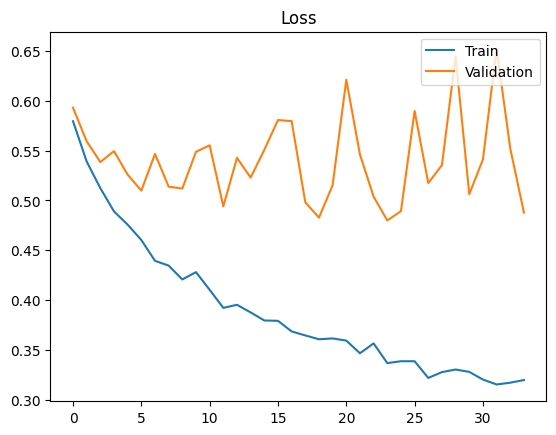

In [14]:
loss_train_curve = history.history["loss"]
loss_val_curve = history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

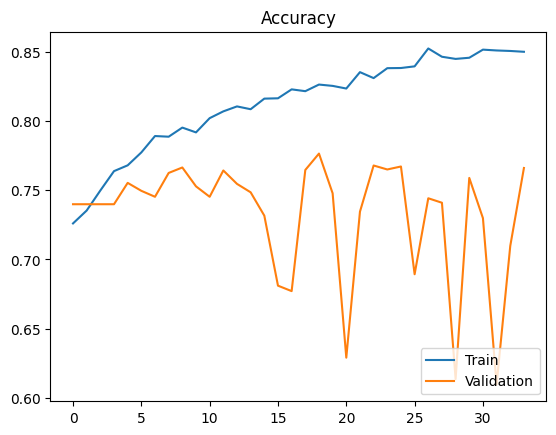

In [15]:
acc_train_curve = history.history["accuracy"]
acc_val_curve = history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()